In [1]:
import sys
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
from functools import partial
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import LlamaTokenizer, LlamaForCausalLM
from tqdm import tqdm
from peft import PeftModel

sys.path.append("../")
from data.data_utils import *

from pp_utils import (
    compute_topk_components,
    eval_circuit_performance,
    get_mean_activations,
    get_random_circuit,
    get_model_and_tokenizer
)
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seed = 5
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

Using device: cuda


## Loading Evaluation Data

In [2]:
model_name = "CohereForAI/c4ai-command-r7b-12-2024"
if model_name == "llama":
    tokenizer = LlamaTokenizer.from_pretrained(
        "hf-internal-testing/llama-tokenizer", padding_side="right"
    )
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.padding_side = "right"
else:
    model, tokenizer = get_model_and_tokenizer("CohereForAI/c4ai-command-r7b-12-2024")
    model.tokenizer = tokenizer

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
data_file = "../data/dataset.jsonl"
batch_size = 50

raw_data = sample_box_data(
    tokenizer=tokenizer,
    num_samples=500,
    data_file=data_file,
)

dataset = Dataset.from_dict(
    {
        "input_ids": raw_data[0],
        "last_token_indices": raw_data[1],
        "labels": raw_data[2],
    }
).with_format("torch")

print(f"Length of dataset: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=batch_size)

Length of dataset: 500


## Loading Circuits

In [4]:
with open("./results/circuits/command_circuit.json", "r") as f:
    command_circuit = json.load(f)

with open("./results/circuits/llama_circuit.json", "r") as f:
    llama_circuit = json.load(f)

with open("./results/circuits/goat_circuit.json", "r") as f:
    goat_circuit = json.load(f)

with open(
    "./results/circuits/float_circuit.json", "r") as f:
    float_circuit = json.load(f)

In [5]:
print("Command Circuit")
print(f"Value Fetcher Heads: {len(command_circuit['value_fetcher'])}")
print(f"Position Transmitter Heads: {len(command_circuit['pos_transmitter'])}")
print(f"Position Detector Heads: {len(command_circuit['pos_detector'])}")
print(f"Structure Reader Heads: {len(command_circuit['struct_reader'])}")
print(
    f"Total Heads: {len(command_circuit['value_fetcher']) + len(command_circuit['pos_transmitter']) + len(command_circuit['pos_detector']) + len(command_circuit['struct_reader'])}"
)

Command Circuit
Value Fetcher Heads: 20
Position Transmitter Heads: 5
Position Detector Heads: 10
Structure Reader Heads: 5
Total Heads: 40


In [6]:
command_circuit

{'struct_reader': [[10, 18], [8, 22], [6, 4], [12, 18], [6, 23]],
 'pos_transmitter': [[18, 24], [19, 16], [19, 19], [19, 1], [20, 28]],
 'pos_detector': [[11, 20],
  [15, 12],
  [13, 19],
  [11, 23],
  [15, 4],
  [13, 17],
  [15, 15],
  [13, 22],
  [5, 9],
  [12, 2]],
 'value_fetcher': [[25, 8],
  [27, 13],
  [23, 17],
  [24, 25],
  [20, 28],
  [27, 21],
  [23, 8],
  [19, 1],
  [20, 30],
  [22, 30],
  [16, 21],
  [18, 8],
  [28, 9],
  [23, 16],
  [19, 16],
  [30, 13],
  [16, 19],
  [22, 23],
  [21, 14],
  [24, 24]],
 'source': 'i made it up (output of minimality.py or path_patching.py?)'}

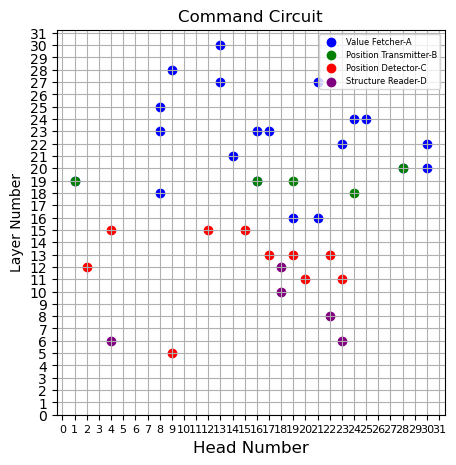

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

def plot_circuit(head_list, color, label):
    for head in head_list:
        head_layer, head_num = head
        ax.scatter(head_num, head_layer, color=color, label=label)

# Plot the circuits
plot_circuit(command_circuit["value_fetcher"], "blue", "Value Fetcher-A")
plot_circuit(command_circuit["pos_transmitter"], "green", "Position Transmitter-B")
plot_circuit(command_circuit["pos_detector"], "red", "Position Detector-C")
plot_circuit(command_circuit["struct_reader"], "purple", "Structure Reader-D")

# Create legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=6)
# make legend slightly smaller

# Set y-ticks for every layer
layers = list(range(32))  # Assuming there are 32 layers
ax.set_xticks(layers)
ax.set_xticklabels(layers)
# change xtick fontsize to 10
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8)
ax.set_yticks(layers)

# add gridlines
ax.grid(which="both")

# Set labels
ax.set_xlabel("Head Number", fontsize=12)
ax.set_ylabel("Layer Number")
ax.set_title("Command Circuit")


plt.show()


In [8]:
print("Llama Circuit")
print(f"Value Fetcher Heads: {len(llama_circuit['value_fetcher'])}")
print(f"Position Transmitter Heads: {len(llama_circuit['pos_transmitter'])}")
print(f"Position Detector Heads: {len(llama_circuit['pos_detector'])}")
print(f"Structure Reader Heads: {len(llama_circuit['struct_reader'])}")
print(
    f"Total Heads: {len(llama_circuit['value_fetcher']) + len(llama_circuit['pos_transmitter']) + len(llama_circuit['pos_detector']) + len(llama_circuit['struct_reader'])}"
)

Llama Circuit
Value Fetcher Heads: 40
Position Transmitter Heads: 7
Position Detector Heads: 20
Structure Reader Heads: 5
Total Heads: 72


In [9]:
print("GOAT CIRCUIT")
print(f"Value Fetcher Heads: {len(goat_circuit['value_fetcher'])}")
print(f"Position Transmitter Heads: {len(goat_circuit['pos_transmitter'])}")
print(f"Position Detector Heads: {len(goat_circuit['pos_detector'])}")
print(f"Structure Reader Heads: {len(goat_circuit['struct_reader'])}")
print(
    f"Total Heads: {len(goat_circuit['value_fetcher']) + len(goat_circuit['pos_transmitter']) + len(goat_circuit['pos_detector']) + len(goat_circuit['struct_reader'])}"
)

GOAT CIRCUIT
Value Fetcher Heads: 68
Position Transmitter Heads: 28
Position Detector Heads: 40
Structure Reader Heads: 39
Total Heads: 175


In [10]:
print("Float Circuit")
print(f"Value Fetcher Heads: {len(float_circuit['value_fetcher'])}")
print(f"Position Transmitter Heads: {len(float_circuit['pos_transmitter'])}")
print(f"Position Detector Heads: {len(float_circuit['pos_detector'])}")
print(f"Structure Reader Heads: {len(float_circuit['struct_reader'])}")
print(
    f"Total Heads: {len(float_circuit['value_fetcher']) + len(float_circuit['pos_transmitter']) + len(float_circuit['pos_detector']) + len(float_circuit['struct_reader'])}"
)

Float Circuit
Value Fetcher Heads: 68
Position Transmitter Heads: 29
Position Detector Heads: 40
Structure Reader Heads: 38
Total Heads: 175


## Helper Methods

In [11]:
def get_circuit(model, circuit_heads):
    circuit_components = {}
    circuit_components[0] = defaultdict(list)
    circuit_components[2] = defaultdict(list)
    circuit_components[-1] = defaultdict(list)

    for layer_idx, head in circuit_heads["value_fetcher"]:
        if model.config.architectures[0] == "LlamaForCausalLM" or model.config.architectures[0] == "Cohere2ForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[0][layer].append(head)

    for layer_idx, head in circuit_heads["pos_transmitter"]:
        if model.config.architectures[0] == "LlamaForCausalLM" or model.config.architectures[0] == "Cohere2ForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[0][layer].append(head)

    for layer_idx, head in circuit_heads["pos_detector"]:
        if model.config.architectures[0] == "LlamaForCausalLM" or model.config.architectures[0] == "Cohere2ForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[2][layer].append(head)

    for layer_idx, head in circuit_heads["struct_reader"]:
        if model.config.architectures[0] == "LlamaForCausalLM" or model.config.architectures[0] == "Cohere2ForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[-1][layer].append(head)

    return circuit_components

In [12]:
def eval_model_performance(model, dataloader):
    total_count = 0
    correct_count = 0
    model.eval()
    with torch.no_grad():
        for _, output in tqdm(enumerate(tqdm(dataloader))):
            for k, v in output.items():
                if v is not None and isinstance(v, torch.Tensor):
                    output[k] = v.to(model.device)

            outputs = model(input_ids=output["input_ids"])

            for bi in range(output["labels"].size(0)):
                label = output["labels"][bi]
                decoded_label = tokenizer.decode(label)
                pred = torch.argmax(
                    outputs.logits[bi][output["last_token_indices"][bi]]
                )
                decoded_pred = tokenizer.decode(pred)

                if label == pred:
                    correct_count += 1
                elif decoded_label.strip() == decoded_pred.strip():
                    correct_count += 1
                total_count += 1

    del outputs
    torch.cuda.empty_cache()

    current_acc = round(correct_count / total_count, 2)
    return current_acc

## Model and Circuit Performance: CR7B

In [13]:
# model, tokenizer = get_model_and_tokenizer("CohereForAI/c4ai-command-r7b-12-2024")
# model.tokenizer = tokenizer

In [14]:
mean_activations, modules = get_mean_activations(
    model, tokenizer, data_file, num_samples=500, batch_size=50
)

Computing mean activations...


  0%|          | 0/10 [00:00<?, ?it/s]The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.
100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


In [15]:
model_acc = eval_model_performance(model, dataloader)
print(f"Model Performance {model_acc}\n")

circuit_components = get_circuit(model, command_circuit)
circuit_acc = eval_circuit_performance(
    model, dataloader, modules, circuit_components, mean_activations
)
print(f"Circuit Performance {circuit_acc}\n")

random_circuit_acc = 0
n_iters = 10
for _ in range(n_iters):
    random_circuit_components = get_random_circuit(model, command_circuit)
    random_circuit_acc += eval_circuit_performance(
        model, dataloader, modules, random_circuit_components, mean_activations
    )
random_circuit_acc = round(random_circuit_acc / n_iters, 2)
print(f"Random Circuit Performance {random_circuit_acc}")

print(f"Faithfulness: {round(circuit_acc/model_acc, 2)}")

100%|██████████| 10/10 [00:04<00:00,  2.23it/s]
10it [00:04,  2.23it/s]

Model Performance 0.83




  0%|          | 0/10 [00:00<?, ?it/s]

tensor([0.8047, 2.0938, 1.1016,  ..., 0.9453, 0.9453, 0.9453], device='cuda:0',
       dtype=torch.bfloat16)
tensor(16.8750, device='cuda:0', dtype=torch.bfloat16)
tensor([0.8438, 2.0938, 1.0625,  ..., 0.9492, 0.9492, 0.9492], device='cuda:0',
       dtype=torch.bfloat16)
tensor(16.7500, device='cuda:0', dtype=torch.bfloat16)
tensor([0.7461, 1.9766, 0.9766,  ..., 0.8789, 0.8789, 0.8789], device='cuda:0',
       dtype=torch.bfloat16)
tensor(16.6250, device='cuda:0', dtype=torch.bfloat16)
tensor([0.7539, 2.0000, 1.0078,  ..., 0.8906, 0.8906, 0.8906], device='cuda:0',
       dtype=torch.bfloat16)
tensor(16.6250, device='cuda:0', dtype=torch.bfloat16)
tensor([0.7617, 2.0156, 1.0156,  ..., 0.8906, 0.8906, 0.8906], device='cuda:0',
       dtype=torch.bfloat16)
tensor(16.7500, device='cuda:0', dtype=torch.bfloat16)
tensor([0.7852, 2.0156, 1.0078,  ..., 0.8945, 0.8945, 0.8945], device='cuda:0',
       dtype=torch.bfloat16)
tensor(16.6250, device='cuda:0', dtype=torch.bfloat16)
tensor([0.6602, 

 10%|█         | 1/10 [01:48<16:16, 108.55s/it]

tensor([0.8125, 2.0312, 1.0938,  ..., 0.9180, 0.9180, 0.9180], device='cuda:0',
       dtype=torch.bfloat16)
tensor(16.6250, device='cuda:0', dtype=torch.bfloat16)
tensor([0.7734, 1.9375, 0.9688,  ..., 0.8555, 0.8555, 0.8555], device='cuda:0',
       dtype=torch.bfloat16)
tensor(16.3750, device='cuda:0', dtype=torch.bfloat16)
tensor([0.7383, 1.8984, 1.0000,  ..., 0.8672, 0.8672, 0.8672], device='cuda:0',
       dtype=torch.bfloat16)
tensor(16.6250, device='cuda:0', dtype=torch.bfloat16)
tensor([0.7227, 1.8984, 0.9688,  ..., 0.8516, 0.8516, 0.8516], device='cuda:0',
       dtype=torch.bfloat16)
tensor(16.6250, device='cuda:0', dtype=torch.bfloat16)


 10%|█         | 1/10 [01:48<16:18, 108.67s/it]


KeyboardInterrupt: 

## Model and Circuit Performance: Llama-7B

In [15]:
# moved the model loading code further up!
# # path = "/home/local_nikhil/Projects/llama_weights/7B"

# # Delete model if present in memory
# if "model" in locals():
#     del model
#     torch.cuda.empty_cache()

# model = LlamaForCausalLM.from_pretrained(path).to(device)

In [13]:
# added this myself
if "model" in locals():
    del model
    torch.cuda.empty_cache()
model, tokenizer = get_model_and_tokenizer("llama")
model.tokenizer = tokenizer

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
mean_activations, modules = get_mean_activations(
    model, tokenizer, data_file, num_samples=500, batch_size=50
)

Computing mean activations...


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


In [15]:
model_acc = eval_model_performance(model, dataloader)
print(f"Model Performance {model_acc}\n")

circuit_components = get_circuit(model, llama_circuit)
circuit_acc = eval_circuit_performance(
    model, dataloader, modules, circuit_components, mean_activations
)
print(f"Circuit Performance {circuit_acc}\n")

random_circuit_acc = 0
n_iters = 10
for _ in range(n_iters):
    random_circuit_components = get_random_circuit(model, llama_circuit)
    random_circuit_acc += eval_circuit_performance(
        model, dataloader, modules, random_circuit_components, mean_activations
    )
random_circuit_acc = round(random_circuit_acc / n_iters, 2)
print(f"Random Circuit Performance {random_circuit_acc}")

print(f"Faithfulness: {round(circuit_acc/model_acc, 2)}")

100%|██████████| 10/10 [00:17<00:00,  1.78s/it]
10it [00:17,  1.78s/it]

Model Performance 0.66




  0%|          | 0/10 [00:00<?, ?it/s]

## Model and Circuit Performance: Vicuna-7B

In [13]:
path = "AlekseyKorshuk/vicuna-7b"

# Delete model if present in memory
if "model" in locals():
    del model
    torch.cuda.empty_cache()

model = LlamaForCausalLM.from_pretrained(path).to(device)

config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00014.bin:   0%|          | 0.00/981M [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

pytorch_model-00002-of-00014.bin:   0%|          | 0.00/967M [00:00<?, ?B/s]

pytorch_model-00003-of-00014.bin:   0%|          | 0.00/967M [00:00<?, ?B/s]

pytorch_model-00004-of-00014.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

pytorch_model-00005-of-00014.bin:   0%|          | 0.00/944M [00:00<?, ?B/s]

pytorch_model-00006-of-00014.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

pytorch_model-00007-of-00014.bin:   0%|          | 0.00/967M [00:00<?, ?B/s]

pytorch_model-00008-of-00014.bin:   0%|          | 0.00/967M [00:00<?, ?B/s]

pytorch_model-00009-of-00014.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

pytorch_model-00010-of-00014.bin:   0%|          | 0.00/944M [00:00<?, ?B/s]

pytorch_model-00011-of-00014.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

pytorch_model-00012-of-00014.bin:   0%|          | 0.00/967M [00:00<?, ?B/s]

pytorch_model-00013-of-00014.bin:   0%|          | 0.00/967M [00:00<?, ?B/s]

pytorch_model-00014-of-00014.bin:   0%|          | 0.00/847M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [14]:
mean_activations, modules = get_mean_activations(
    model, tokenizer, data_file, num_samples=500, batch_size=50
)

Computing mean activations...


100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


In [15]:
model_acc = eval_model_performance(model, dataloader)
print(f"Model Performance {model_acc}\n")

circuit_components = get_circuit(model, llama_circuit)
circuit_acc = eval_circuit_performance(
    model, dataloader, modules, circuit_components, mean_activations
)
print(f"Circuit Performance {circuit_acc}\n")

random_circuit_acc = 0
n_iters = 10
for _ in range(n_iters):
    random_circuit_components = get_random_circuit(model, llama_circuit)
    random_circuit_acc += eval_circuit_performance(
        model, dataloader, modules, random_circuit_components, mean_activations
    )
random_circuit_acc = round(random_circuit_acc / n_iters, 2)
print(f"Random Circuit Performance {random_circuit_acc}\n")

print(f"Faithfulness: {round(circuit_acc/model_acc, 2)}")

100%|██████████| 10/10 [00:17<00:00,  1.71s/it]
10it [00:17,  1.71s/it]


Model Performance 0.67



100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


Circuit Performance 0.65



100%|██████████| 10/10 [00:44<00:00,  4.40s/it]

Random Circuit Performance 0.0

Faithfulness: 0.97


## Model and Circuit Performance: Goat-7B

In [17]:
base_model = "luodian/llama-7b-hf"
lora_weights = "tiedong/goat-lora-7b"

# Delete model if present in memory
if "model" in locals():
    del model
    torch.cuda.empty_cache()

model = LlamaForCausalLM.from_pretrained(
    base_model,
    load_in_8bit=False,
    torch_dtype=torch.float32,
    device_map="auto",
)
model = PeftModel.from_pretrained(
    model,
    lora_weights,
    torch_dtype=torch.float32,
    device_map={"": 0},
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

In [18]:
mean_activations, modules = get_mean_activations(
    model, tokenizer, data_file, num_samples=500, batch_size=50
)

Computing mean activations...


  0%|          | 0/10 [00:00<?, ?it/s]


LookupError: model.layers.0.self_attn.o_proj

In [18]:
model_acc = eval_model_performance(model, dataloader)
print(f"Model Performance: {model_acc}\n")

circuit_components = get_circuit(model, llama_circuit)
circuit_acc = eval_circuit_performance(
    model, dataloader, modules, circuit_components, mean_activations
)
print(f"Circuit Performance: {circuit_acc}\n")

random_circuit_acc = 0
n_iters = 10
for _ in range(n_iters):
    random_circuit_components = get_random_circuit(model, llama_circuit)
    random_circuit_acc += eval_circuit_performance(
        model, dataloader, modules, random_circuit_components, mean_activations
    )
random_circuit_acc = round(random_circuit_acc / n_iters, 2)
print(f"Random Circuit Performance {random_circuit_acc}\n")

print(f"Faithfulness: {round(circuit_acc/model_acc, 2)}")

100%|██████████| 10/10 [00:22<00:00,  2.23s/it]
10it [00:22,  2.23s/it]


Model Performance: 0.82



100%|██████████| 10/10 [00:45<00:00,  4.60s/it]


Circuit Performance: 0.73



100%|██████████| 10/10 [00:46<00:00,  4.69s/it]

Random Circuit Performance 0.01

Faithfulness: 0.89


## Model and Circuit Performance: Float-7B

In [19]:
path = "nikhil07prakash/float-7b"

# Delete model if present in memory
if "model" in locals():
    del model
    torch.cuda.empty_cache()

model = LlamaForCausalLM.from_pretrained(path).to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
mean_activations, modules = get_mean_activations(
    model, tokenizer, data_file, num_samples=500, batch_size=50
)

Computing mean activations...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


In [21]:
model_acc = eval_model_performance(model, dataloader)
print(f"Model Performance {model_acc}")

circuit_components = get_circuit(model, llama_circuit)
circuit_acc = eval_circuit_performance(
    model, dataloader, modules, circuit_components, mean_activations
)
print(f"Circuit Performance {circuit_acc}")

random_circuit_acc = 0
n_iters = 10
for _ in range(n_iters):
    random_circuit_components = get_random_circuit(model, llama_circuit)
    random_circuit_acc += eval_circuit_performance(
        model, dataloader, modules, random_circuit_components, mean_activations
    )
random_circuit_acc = round(random_circuit_acc / n_iters, 2)
print(f"Random Circuit Performance {random_circuit_acc}\n")

print(f"Faithfulness: {round(circuit_acc/model_acc, 2)}")

100%|██████████| 10/10 [00:21<00:00,  2.18s/it]
10it [00:21,  2.18s/it]


Model Performance 0.82


100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


Circuit Performance 0.72


100%|██████████| 10/10 [00:45<00:00,  4.51s/it]

Random Circuit Performance 0.01

Faithfulness: 0.88


## Circuit Comparison

In [7]:
head_groups = ["value_fetcher", "pos_transmitter", "pos_detector", "struct_reader"]

for head_group in head_groups:
    intersection = 0
    for l, h in llama_circuit[head_group]:
        if [l, h] in float_circuit[head_group]:
            intersection += 1

    precision = round(intersection / len(llama_circuit[head_group]), 2)
    recall = round(intersection / len(float_circuit[head_group]), 2)

    print(
        f"{head_group}: {len(llama_circuit[head_group])} | {len(float_circuit[head_group])} | {intersection} | {precision} | {recall}"
    )

value_fetcher: 40 | 68 | 27 | 0.68 | 0.4
pos_transmitter: 7 | 29 | 7 | 1.0 | 0.24
pos_detector: 20 | 40 | 15 | 0.75 | 0.38
struct_reader: 5 | 38 | 5 | 1.0 | 0.13


In [55]:
n_value_fetcher = 58
n_pos_trans = 10
n_pos_detect = 25
n_struct_read = 5
pp_llama_root = "./results/path_patching/llama_circuit"

path = f"{pp_llama_root}/value_fetcher.pt"
patching_scores = torch.load(path)
top_value_fetcher_llama_heads, top_value_fetcher_llama_score = compute_topk_components(
    patching_scores, k=n_value_fetcher, largest=False, return_values=True
)

path = f"{pp_llama_root}/pos_transmitter.pt"
patching_scores = torch.load(path)
(
    top_pos_transmitter_llama_heads,
    top_pos_transmitter_llama_score,
) = compute_topk_components(
    patching_scores, k=n_pos_trans, largest=False, return_values=True
)

path = f"{pp_llama_root}/pos_detector.pt"
patching_scores = torch.load(path)
top_pos_detector_llama_heads, top_pos_detector_llama_score = compute_topk_components(
    patching_scores, k=n_pos_detect, largest=False, return_values=True
)

path = f"{pp_llama_root}/struct_reader.pt"
patching_scores = torch.load(path)
top_struct_reader_llama_heads, top_struct_reader_llama_score = compute_topk_components(
    patching_scores, k=n_struct_read, largest=False, return_values=True
)

# If a head is present in both top value_fetcher and position_transmitter, then
# remove it from the top value_fetcher heads.
intersection = []
for head in top_value_fetcher_llama_heads:
    if head in top_pos_transmitter_llama_heads:
        intersection.append(head)

for head in intersection:
    idx = top_value_fetcher_llama_heads.index(head)
    top_value_fetcher_llama_heads.pop(idx)
    top_value_fetcher_llama_score.pop(idx)

print(f"Value Fetcher: {len(top_value_fetcher_llama_heads)}")
print(f"Position Transmitter: {len(top_pos_transmitter_llama_heads)}")
print(f"Position Detector: {len(top_pos_detector_llama_heads)}")
print(f"Structure Reader: {len(top_struct_reader_llama_heads)}")

Value Fetcher: 50
Position Transmitter: 10
Position Detector: 25
Structure Reader: 5


In [56]:
llama_value_fetcher = llama_circuit["value_fetcher"]
llama_pos_transmitter = llama_circuit["pos_transmitter"]
llama_pos_detector = llama_circuit["pos_detector"]
llama_struct_reader = llama_circuit["struct_reader"]

print(
    len(llama_value_fetcher),
    len(llama_pos_transmitter),
    len(llama_pos_detector),
    len(llama_struct_reader),
)

40 7 20 5


In [57]:
# Create list of tuple of (head, patching_score, position) for each group in llama circuit
llama_value_fetcher_tuple = []
for head, score in zip(top_value_fetcher_llama_heads, top_value_fetcher_llama_score):
    llama_value_fetcher_tuple.append((head, abs(score), 0))

llama_pos_transmitter_tuple = []
for head, score in zip(
    top_pos_transmitter_llama_heads, top_pos_transmitter_llama_score
):
    llama_pos_transmitter_tuple.append((head, abs(score), 0))

llama_pos_detector_tuple = []
for head, score in zip(top_pos_detector_llama_heads, top_pos_detector_llama_score):
    llama_pos_detector_tuple.append((head, abs(score), 2))

llama_struct_reader_tuple = []
for head, score in zip(top_struct_reader_llama_heads, top_struct_reader_llama_score):
    llama_struct_reader_tuple.append((head, abs(score), -1))

llama_circuit_tuple = (
    llama_value_fetcher_tuple
    + llama_pos_transmitter_tuple
    + llama_pos_detector_tuple
    + llama_struct_reader_tuple
)
llama_circuit_tuple = sorted(llama_circuit_tuple, key=lambda x: x[1], reverse=True)

In [58]:
n_value_fetcher = 102
n_pos_trans = 30
n_pos_detect = 50
n_struct_read = 40
pp_float_root = "./results/path_patching/float_circuit"

path = f"{pp_float_root}/value_fetcher.pt"
patching_scores = torch.load(path)
top_value_fetcher_float_heads, top_value_fetcher_float_score = compute_topk_components(
    patching_scores, k=n_value_fetcher, largest=False, return_values=True
)

path = f"{pp_float_root}/pos_transmitter.pt"
patching_scores = torch.load(path)
(
    top_pos_transmitter_float_heads,
    top_pos_transmitter_float_score,
) = compute_topk_components(
    patching_scores, k=n_pos_trans, largest=False, return_values=True
)

path = f"{pp_float_root}/pos_detector.pt"
patching_scores = torch.load(path)
top_pos_detector_float_heads, top_pos_detector_float_score = compute_topk_components(
    patching_scores, k=n_pos_detect, largest=False, return_values=True
)

path = f"{pp_float_root}/struct_reader.pt"
patching_scores = torch.load(path)
top_struct_reader_float_heads, top_struct_reader_float_score = compute_topk_components(
    patching_scores, k=n_struct_read, largest=False, return_values=True
)

# If a head is present in both top value_fetcher and position_transmitter, then
# remove it from the top value_fetcher heads.
intersection = []
for head in top_value_fetcher_float_heads:
    if head in top_pos_transmitter_float_heads:
        intersection.append(head)

for head in intersection:
    idx = top_value_fetcher_float_heads.index(head)
    top_value_fetcher_float_heads.pop(idx)
    top_value_fetcher_float_score.pop(idx)

print(f"Value Fetcher: {len(top_value_fetcher_float_heads)}")
print(f"Position Transmitter: {len(top_pos_transmitter_float_heads)}")
print(f"Position Detector: {len(top_pos_detector_float_heads)}")
print(f"Structure Reader: {len(top_struct_reader_float_heads)}")

Value Fetcher: 80
Position Transmitter: 30
Position Detector: 50
Structure Reader: 40


In [59]:
float_value_fetcher = float_circuit["value_fetcher"]
float_pos_transmitter = float_circuit["pos_transmitter"]
float_pos_detector = float_circuit["pos_detector"]
float_struct_reader = float_circuit["struct_reader"]

print(
    len(float_value_fetcher),
    len(float_pos_transmitter),
    len(float_pos_detector),
    len(float_struct_reader),
)

68 29 40 38


In [60]:
# Create list of tuple of (head, patching_score, position) for each group in Goat circuit
float_value_fetcher_tuple = []
for head, score in zip(top_value_fetcher_float_heads, top_value_fetcher_float_score):
    float_value_fetcher_tuple.append((head, abs(score), 0))

float_pos_transmitter_tuple = []
for head, score in zip(top_pos_transmitter_float_heads, top_pos_transmitter_float_score):
    float_pos_transmitter_tuple.append((head, abs(score), 0))

float_pos_detector_tuple = []
for head, score in zip(top_pos_detector_float_heads, top_pos_detector_float_score):
    float_pos_detector_tuple.append((head, abs(score), 2))

float_struct_reader_tuple = []
for head, score in zip(top_struct_reader_float_heads, top_struct_reader_float_score):
    float_struct_reader_tuple.append((head, abs(score), -1))

float_circuit_tuple = (
    float_value_fetcher_tuple
    + float_pos_transmitter_tuple
    + float_pos_detector_tuple
    + float_struct_reader_tuple
)
float_circuit_tuple = sorted(float_circuit_tuple, key=lambda x: x[1], reverse=True)

In [61]:
# For each head in float_circuit_tuple, find the corresponding head in llama_circuit_tuple
# and append it to a new list. If the head is not present in llama_circuit_tuple, then
# append it the same list with a patching score of 0.
ordered_llama_circuit_tuple = []
for f_head, f_score, f_pos in float_circuit_tuple:
    found = False
    for l_head, l_score, l_pos in llama_circuit_tuple:
        if f_head == l_head and f_pos == l_pos:
            ordered_llama_circuit_tuple.append((l_head, l_score, l_pos))
            found = True
            break

    if not found:
        ordered_llama_circuit_tuple.append((f_head, 0, f_pos))

[]

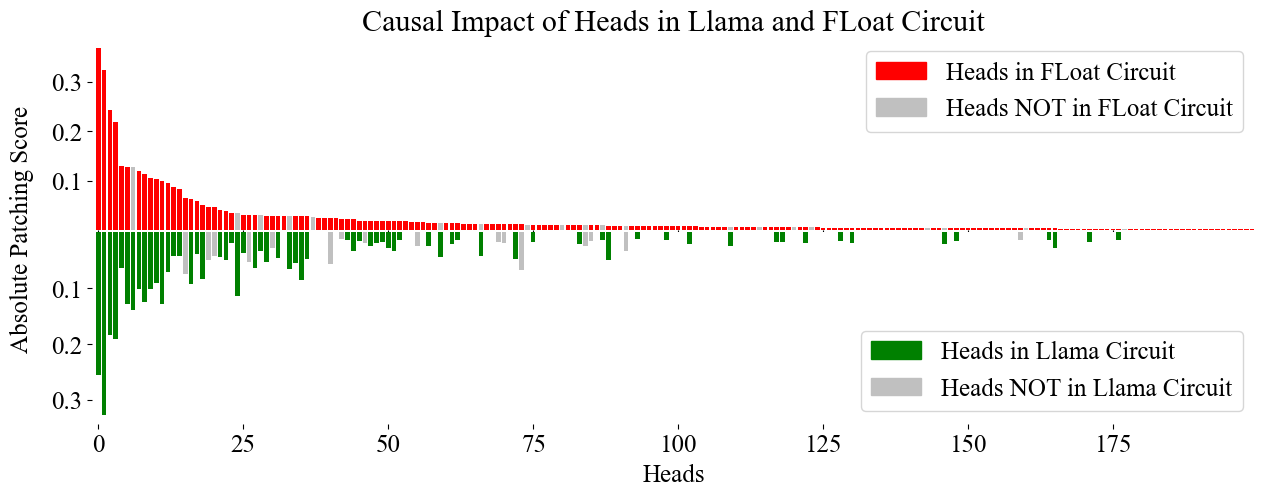

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

# Use times new roman font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18

ax1.bar(
    [i for i in range(len(float_circuit_tuple))],
    [score for _, score, _ in float_circuit_tuple],
    color="red",
)
for i in range(len(float_circuit_tuple)):
    if (
        float_circuit_tuple[i][0] not in float_value_fetcher
        and float_circuit_tuple[i][0] not in float_pos_transmitter
        and float_circuit_tuple[i][0] not in float_pos_detector
        and float_circuit_tuple[i][0] not in float_struct_reader
    ):
        ax1.bar(
            i,
            float_circuit_tuple[i][1],
            color="silver",
        )

red_patch = mpatches.Patch(color="red", label="Heads in FLoat Circuit")
silver_patch = mpatches.Patch(color="silver", label="Heads NOT in FLoat Circuit")
ax1.legend(handles=[red_patch, silver_patch], loc="upper right")

ax2.bar(
    [i for i in range(len(ordered_llama_circuit_tuple))],
    [score for _, score, _ in ordered_llama_circuit_tuple],
    color="green",
)
for i in range(len(ordered_llama_circuit_tuple)):
    if (
        ordered_llama_circuit_tuple[i][0] not in llama_value_fetcher
        and ordered_llama_circuit_tuple[i][0] not in llama_pos_transmitter
        and ordered_llama_circuit_tuple[i][0] not in llama_pos_detector
        and ordered_llama_circuit_tuple[i][0] not in llama_struct_reader
    ):
        ax2.bar(
            i,
            ordered_llama_circuit_tuple[i][1],
            color="silver",
        )

green_patch = mpatches.Patch(color="green", label="Heads in Llama Circuit")
silver_patch = mpatches.Patch(color="silver", label="Heads NOT in Llama Circuit")
ax2.legend(handles=[green_patch, silver_patch], loc="lower right")

# Remove the blank space before and after the bar chart
plt.xlim(-1, 200 - 0.5)

# Reduce the gap between the two subplots
plt.subplots_adjust(hspace=0.01)
# Flip the y-axis of the second subplot
ax2.invert_yaxis()
# Remove 0.0 from the y-axis of the second subplot
ax1.set_yticks([0.1, 0.2, 0.3])
ax2.set_yticks([0.1, 0.2, 0.3])

# Set a single y-axis label for both subplots
fig.text(0.07, 0.5, "Absolute Patching Score", va="center", rotation="vertical")

ax2.set_xlabel("Heads")
ax1.set_title("Causal Impact of Heads in Llama and FLoat Circuit")

# Remove plox plot frame
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["left"].set_visible(False)

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["left"].set_visible(False)

# Save the plot
# plt.plot()
plt.savefig("./results/figures/float_llama_causal_impact.pdf", bbox_inches="tight", dpi=300)